In [1]:
import cv2
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import matplotlib.pyplot as plt
from skimage import io, color, data, filters
import numpy as np
import os
import shutil

In [60]:
data_path = 'sciFinder-spectrum'

### Load img and pre-process

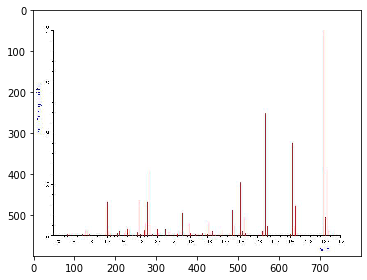

In [61]:
img = io.imread('{}/MS/98-56-6.png'.format(data_path))
io.imshow(img)

In [502]:
type(img)

numpy.ndarray

#### Thresholding

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/user/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: binary.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.


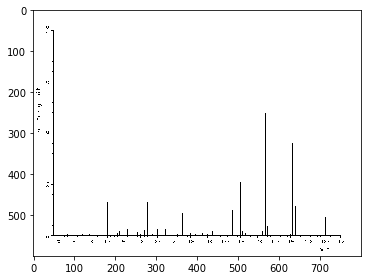

In [62]:
def Thresholding(img, threshold):
    img_gray=color.rgb2gray(img)
    rows,cols=img_gray.shape
    for i in range(rows):
        for j in range(cols):
            if (img_gray[i,j]<=threshold):
                img_gray[i,j]=0
            else:
                img_gray[i,j]=1
    return img_gray


## turn to gray img
img_gray = color.rgb2gray(img)

io.imsave("base_img.png", img_gray)
## get the edge of img
edges = filters.sobel(img_gray)

thresh = filters.threshold_li(img_gray)

binary = img_gray > thresh

io.imsave("binary.png", binary)
io.imshow(binary)

#### Split to three parts

- xLabel

- yLabel

- data content

In [63]:
## xlabel 
vertical_distribution = np.sum(~binary, axis=1)
vertical_distribution

x_splits = []
item = []
start = False
for i in range(len(vertical_distribution)):
    if len(item) > 0 and vertical_distribution[i] == 0:
        x_splits.append(item)
        item = []
    if vertical_distribution[i] > 0:
        item.append(i)
        
x_splits[-2] 

[561, 562, 563, 564, 565, 566, 567, 568]

/home/user/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: xLabel.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  after removing the cwd from sys.path.


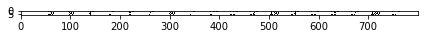

In [503]:

xlabel = binary[x_splits[-2], :]

io.imshow(xlabel)
io.imsave("xLabel.png", xlabel)

In [23]:
## ylabel
horizon_distribution = np.sum(~binary, axis=0)
horizon_distribution

y_splits = []
item = []
start = False
for i in range(len(horizon_distribution)):
    if len(item) > 0 and horizon_distribution[i] == 0:
        y_splits.append(item)
        item = []
    if horizon_distribution[i] > 0:
        item.append(i)
        
y_splits[1]

[31, 32, 33, 34, 35, 36, 37, 38]

/home/user/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: yLabel.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  This is separate from the ipykernel package so we can avoid doing imports until


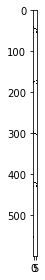

In [24]:
ylabel = binary[:, y_splits[1]]
io.imshow(ylabel)
io.imsave("yLabel.png", ylabel)

/home/user/miniconda/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
/home/user/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: content.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  """
/home/user/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: content.png is a low contrast image
  """


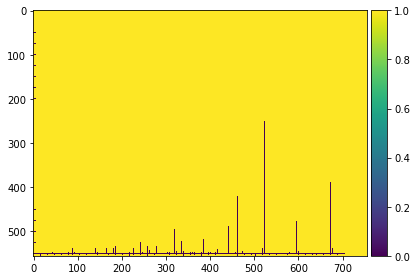

In [408]:
## content 
content = binary[:x_splits[-3][-1], :]
content = content[:, y_splits[2][0]:]
io.imshow(content)
io.imsave("content.png", content)

### recognize the label

Identify coordinate values and establish the real coordinate system in the picture

In [44]:
import easyocr

In [105]:
reader = easyocr.Reader(['en'])

In [106]:
IMAGE_PATH = "xLabel.png"
xl = io.imread(IMAGE_PATH)

result = reader.readtext(IMAGE_PATH, paragraph="False", min_size=1)
result

[[[[298, 4], [310, 4], [310, 12], [298, 12]], '30'],
 [[[377, 3], [399, 3], [399, 15], [377, 15]], '10Q'],
 [[[419, 3], [441, 3], [441, 15], [419, 15]], '110'],
 [[[459, 3], [481, 3], [481, 15], [459, 15]], '120'],
 [[[499, 3], [521, 3], [521, 15], [499, 15]], '130'],
 [[[542, 4], [560, 4], [560, 12], [542, 12]], '140'],
 [[[581, 3], [603, 3], [603, 15], [581, 15]], '15Q'],
 [[[621, 3], [643, 3], [643, 15], [621, 15]], '160'],
 [[[661, 3], [683, 3], [683, 15], [661, 15]], '170'],
 [[[703, 3], [725, 3], [725, 15], [703, 15]], '180'],
 [[[743, 3], [765, 3], [765, 15], [743, 15]], '19Q']]

In [76]:
xl.shape

(20, 800)

#### train CNN to recognize numbers

In [2]:
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
import torch, glob
import matplotlib.font_manager as fm
import torch.nn.functional as F
from PIL import Image, ImageFont, ImageDraw
from copy import deepcopy
import random
from skimage import morphology as mo
from skimage import transform as tr

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

##### generate dataset

In [7]:
class LabelDataset(Dataset):#需要继承data.Dataset
    def __init__(self,size=100000):
        self.tag_set = ['0','1','2','3','4','5','6','7','8','9', '.', ' ', '-']
        self.font_files = glob.glob('./font_family/*')
        self.x_list = [20,25,30]
        self.y_list = [0,1,2,3,4,5,6]
        self.size = size
        
    def __getitem__(self, index):
        x = self.random_select(self.x_list)
        y = self.random_select(self.y_list)
        fn = self.random_select(self.font_files)
        tag = self.random_select(self.tag_set)
        index = self.tag_set.index(tag)
        fm_ = fm.FontProperties(fname=fn)
        tag_im = self.gentag(tag,x,y,70,70,'',fm_)
        tag_array = np.array(tag_im)
        tag_array = tag_array == [255,255,255]
        tag_array = np.all(tag_array,axis=2)
        tag_array = 1-tag_array.astype(np.float32)
        return torch.tensor(tag_array).float(),torch.tensor([index]).long()
    
    def __len__(self):
        # You should change 0 to the total size of your dataset.
        return self.size
    
    def gentag(self, tag,x,y,image_l=250,image_h=40,file='',fm_=fm.FontProperties(family='DejaVu Sans')):
        size = self.random_select(label_size)
        text = tag
        im = Image.new("RGB", (image_l, image_h), (255, 255, 255))
        dr = ImageDraw.Draw(im)
        font = ImageFont.truetype(fm.findfont(fm_), size)
        dr.text((x, y), text, font=font, fill="#000000")
        if file != '':
            im.save(file)
        return im
    
    @staticmethod
    def random_select(items):
        rand_idx = random.randint(0,len(items)-1)
        return items[rand_idx]
    
class MyCNN(nn.Module):

    def __init__(self, numclasses=3):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=3,padding=1,bias=False)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=2, dilation=2,bias=False,groups=2)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=4, dilation=4,bias=False,groups=2)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=4, dilation=4,bias=False,groups=2)
        self.pool = nn.AdaptiveMaxPool2d((1,1))
        self.lin = nn.Conv2d(128,numclasses,kernel_size=1)
        #self.lin2 = nn.Linear(128,numclasses)

    def forward(self, x):

        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.lin(x)
        x = x.squeeze(2)
        x = x.squeeze(2)
        return x

In [8]:
glob.glob('./font_family/*')

['./font_family/ARIALN.TTF',
 './font_family/ARIALNI.TTF',
 './font_family/ARIALNBI.TTF',
 './font_family/TIMESBD.TTF',
 './font_family/ARIALI.TTF',
 './font_family/ARIALBI.TTF',
 './font_family/TIMES.TTF',
 './font_family/ARIALNB.TTF',
 './font_family/TIMESI.TTF',
 './font_family/ARIAL.TTF',
 './font_family/TIMESBI.TTF',
 './font_family/ARIBLK.TTF',
 './font_family/ARIALBD.TTF']

##### define model

In [9]:
label_size = [60,50,40,35,30,25,20]
train_label_set = LabelDataset(100000)
test_label_set = LabelDataset(10000)
train_load = DataLoader(train_label_set,batch_size=256,shuffle=True)
test_load = DataLoader(test_label_set,batch_size=256,shuffle=True)
recog_label_model = MyCNN(len(train_label_set.tag_set))
recog_label_model.to(device)
recog_label_model = nn.DataParallel(recog_label_model,device_ids=[0,1])
criterion = nn.CrossEntropyLoss()

In [10]:
len(train_label_set.tag_set)

13

In [11]:
train_label_set[0][0].shape

torch.Size([70, 70])

##### train CNN

In [12]:
learning_rate = 1e-3
optimizer = optim.Adam(recog_label_model.parameters(), lr=learning_rate)

loss_hist = []
all_acc = []
for epoch in range(50):
    all_pred = []
    all_tag = []
    all_loss = []
    for idx,tmp_load in enumerate(train_load):
        optimizer.zero_grad()
        input_tensor = tmp_load[0].to(device)
        tag_tensor = tmp_load[1].to(device).squeeze()
        output = recog_label_model(input_tensor)
        
        predict = output.detach().cpu().topk(1)[1].view(-1).numpy()
        target = tag_tensor.detach().cpu().numpy()
        
        loss = criterion(output,tag_tensor)
        loss.backward()
        optimizer.step()
        loss_hist.append(loss)
        all_loss.append(loss.detach().cpu())
        all_pred.append(predict)
        all_tag.append(target)
        #break
    all_pred = np.concatenate(all_pred)
    all_tag = np.concatenate(all_tag)
    accuracy = np.mean(all_tag == all_pred)
    all_acc.append(accuracy)
    print('Epoch: %3d Loss: %.4f, Accuracy: %.4f'%(epoch,np.mean(all_loss),accuracy))
    torch.save(recog_label_model.state_dict(),'./model/recog_label_model.pth')
    #break

Epoch:   0 Loss: 0.3528, Accuracy: 0.9424
Epoch:   1 Loss: 0.1412, Accuracy: 1.0000
Epoch:   2 Loss: 0.1025, Accuracy: 1.0000
Epoch:   3 Loss: 0.0705, Accuracy: 1.0000
Epoch:   4 Loss: 0.0509, Accuracy: 1.0000
Epoch:   5 Loss: 0.0346, Accuracy: 1.0000
Epoch:   6 Loss: 0.0249, Accuracy: 1.0000
Epoch:   7 Loss: 0.0181, Accuracy: 1.0000
Epoch:   8 Loss: 0.0134, Accuracy: 1.0000
Epoch:   9 Loss: 0.0100, Accuracy: 1.0000
Epoch:  10 Loss: 0.0078, Accuracy: 1.0000
Epoch:  11 Loss: 0.0061, Accuracy: 1.0000
Epoch:  12 Loss: 0.0049, Accuracy: 1.0000
Epoch:  13 Loss: 0.0038, Accuracy: 1.0000
Epoch:  14 Loss: 0.0031, Accuracy: 1.0000
Epoch:  15 Loss: 0.0025, Accuracy: 1.0000
Epoch:  16 Loss: 0.0020, Accuracy: 1.0000
Epoch:  17 Loss: 0.0016, Accuracy: 1.0000
Epoch:  18 Loss: 0.0014, Accuracy: 1.0000
Epoch:  19 Loss: 0.0011, Accuracy: 1.0000
Epoch:  20 Loss: 0.0009, Accuracy: 1.0000
Epoch:  21 Loss: 0.0007, Accuracy: 1.0000
Epoch:  22 Loss: 0.0006, Accuracy: 1.0000
Epoch:  23 Loss: 0.0005, Accuracy:

In [13]:
!nvidia-smi

Thu Apr 21 10:42:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 85%   71C    P2    53W / 215W |   6691MiB /  7979MiB |     19%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
| 70%   

##### model evaluation

In [13]:
recog_label_model.eval()
all_pred = []
all_tag = []
for idx,tmp_load in enumerate(test_load):
    input_tensor = tmp_load[0].to(device)
    tag_tensor = tmp_load[1].to(device).squeeze()
    output = recog_label_model(input_tensor)
    predict = output.detach().cpu().topk(1)[1].view(-1).numpy()
    target = tag_tensor.detach().cpu().numpy()
    all_pred.append(predict)
    all_tag.append(target)
all_pred = np.concatenate(all_pred)
all_tag = np.concatenate(all_tag)
accuracy = np.mean(all_tag == all_pred)

In [14]:
all_tag

array([ 3,  3, 10, ...,  0,  6,  9])

In [15]:
print('Test Acc: %.4f'%accuracy)

Test Acc: 1.0000


In [16]:
all_acc

[0.99996,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.99531,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

Predict label is: ., Truth label is: .


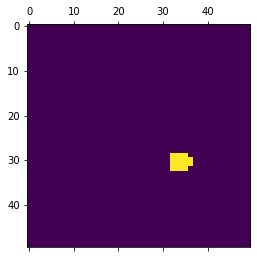

In [18]:
idx = 3
print('Predict label is: %s, Truth label is: %s'%(train_label_set.tag_set[predict[idx]],train_label_set.tag_set[target[idx]]))
plt.matshow(input_tensor[idx].detach().cpu())

#### split xLabel to blocks

In [161]:
def resizefig(array,x_bias,y_bias,canvas_size=1000):
    x,y = array.shape
    canvas = np.zeros((canvas_size,canvas_size))

    canvas[x_bias:x+x_bias,y_bias:y+y_bias] = array
    return canvas

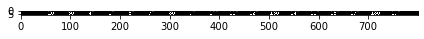

In [144]:
xlabel_cut = ~xlabel
io.imshow(xlabel_cut)

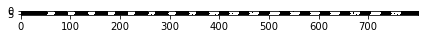

In [167]:
kernel = mo.disk(2)
dilated = mo.binary_dilation(xlabel_cut, kernel)
io.imshow(dilated)

In [168]:
## split xLabel
horizon_distribution = np.sum(dilated, axis=0)
horizon_distribution

x_label_splits = []
item = []
start = False
for i in range(len(horizon_distribution)):
    if len(item) > 0 and horizon_distribution[i] == 0:
        x_label_splits.append(item)
        item = []
    if horizon_distribution[i] > 0:
        item.append(i)

In [169]:
x_label_splits

[[53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
 [93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107],
 [134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148],
 [174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188],
 [215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229],
 [255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269],
 [296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310],
 [337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351],
 [377,
  378,
  379,
  380,
  381,
  382,
  383,
  384,
  385,
  386,
  387,
  388,
  389,
  390,
  391,
  392,
  393,
  394,
  395,
  396,
  397],
 [418,
  419,
  420,
  421,
  422,
  423,
  424,
  425,
  426,
  427,
  428,
  429,
  430,
  431,
  432,
  433,
  434,
  435,
  436,
  437,
  438],
 [458,
  459,
  460,
  461,
  462,
  463,
  464,
  465,
  466,
  467,
  468,
  469,
  470,
  471,
  47

In [184]:
## x_label_splits : the numbers x list
xLabels = []
for i in x_label_splits:
    xLabels.append(~xlabel[:, i])


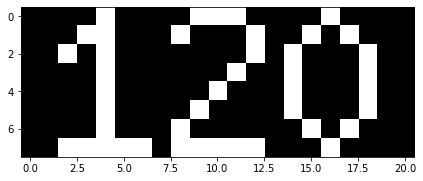

In [185]:
io.imshow(xLabels[10])

In [188]:
x_Numbers = []
for i in xLabels:
    x_numbers = []
    horizon_distribution = np.sum(i, axis=0)
    item = []
    start = False
    for j in range(len(horizon_distribution)):
        if len(item) > 0 and horizon_distribution[j] == 0:
            x_numbers.append(item)
            item = []
        if horizon_distribution[j] > 0:
            item.append(j)
    x_Numbers.append(x_numbers)


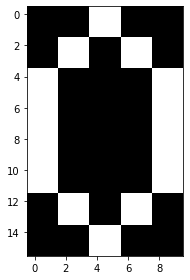

In [263]:
io.imshow(tr.rescale(xLabels[0][:, x_Numbers[0][1]], 2))

In [190]:
x_Numbers

[[[2, 3, 4, 5, 6], [8, 9, 10, 11, 12]],
 [[2, 3, 4, 5, 6], [8, 9, 10, 11, 12]],
 [[2, 3, 4, 5, 6], [8, 9, 10, 11, 12]],
 [[2, 3, 4, 5, 6], [8, 9, 10, 11, 12]],
 [[2, 3, 4, 5, 6], [8, 9, 10, 11, 12]],
 [[2, 3, 4, 5, 6], [8, 9, 10, 11, 12]],
 [[2, 3, 4, 5, 6], [8, 9, 10, 11, 12]],
 [[2, 3, 4, 5, 6], [8, 9, 10, 11, 12]],
 [[2, 3, 4, 5, 6], [8, 9, 10, 11, 12], [14, 15, 16, 17, 18]],
 [[2, 3, 4, 5, 6], [8, 9, 10, 11, 12], [14, 15, 16, 17, 18]],
 [[2, 3, 4, 5, 6], [8, 9, 10, 11, 12], [14, 15, 16, 17, 18]],
 [[2, 3, 4, 5, 6], [8, 9, 10, 11, 12], [14, 15, 16, 17, 18]],
 [[2, 3, 4, 5, 6], [8, 9, 10, 11, 12], [14, 15, 16, 17, 18]],
 [[2, 3, 4, 5, 6], [8, 9, 10, 11, 12], [14, 15, 16, 17, 18]],
 [[2, 3, 4, 5, 6], [8, 9, 10, 11, 12], [14, 15, 16, 17, 18]],
 [[2, 3, 4, 5, 6], [8, 9, 10, 11, 12], [14, 15, 16, 17, 18]],
 [[2, 3, 4, 5, 6], [8, 9, 10, 11, 12], [14, 15, 16, 17, 18]],
 [[2, 3, 4, 5, 6], [8, 9, 10, 11, 12], [14, 15, 16, 17, 18]]]

#### split yLabel to blocks

/home/user/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: y_rotated.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  """


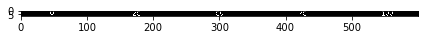

In [347]:
ylabel_cut = ~ylabel
y_rotated = tr.rotate(ylabel_cut, angle=-90, resize=True)
y_rotated = np.array(y_rotated, dtype=bool)
io.imshow(y_rotated)
io.imsave("y_rotated.png", y_rotated)

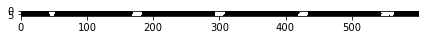

In [348]:
kernel = mo.disk(2)
y_dilated = mo.binary_dilation(y_rotated, kernel)
io.imshow(y_dilated)

In [349]:
## split yLabel
horizon_distribution = np.sum(y_dilated, axis=0)

y_label_splits = []
item = []
start = False
for i in range(len(horizon_distribution)):
    if len(item) > 0 and horizon_distribution[i] == 0:
        y_label_splits.append(item)
        item = []
    if horizon_distribution[i] > 0:
        item.append(i)

In [350]:
y_label_splits

[[42, 43, 44, 45, 46, 47, 48, 49, 50],
 [167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181],
 [292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306],
 [417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431],
 [542,
  543,
  544,
  545,
  546,
  547,
  548,
  549,
  550,
  551,
  552,
  553,
  554,
  555,
  556,
  557,
  558,
  559,
  560,
  561,
  562]]

In [351]:
## y_label_splits : the numbers y list
yLabels = []
for i in y_label_splits:
    yLabels.append(y_rotated[:, i])


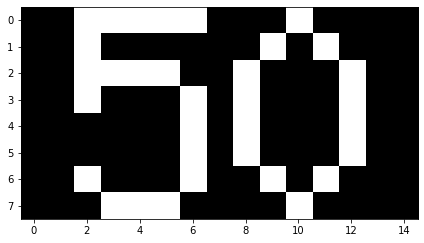

In [352]:
io.imshow(yLabels[2])

In [353]:
y_Numbers = []
for i in yLabels:
    y_numbers = []
    horizon_distribution = np.sum(i, axis=0)
    item = []
    start = False
    for j in range(len(horizon_distribution)):
        if len(item) > 0 and horizon_distribution[j] == 0:
            y_numbers.append(item)
            item = []
        if horizon_distribution[j] > 0:
            item.append(j)
    y_Numbers.append(y_numbers)

In [354]:
yLabels[0]

array([[False, False, False, False,  True, False, False, False, False],
       [False, False, False,  True, False,  True, False, False, False],
       [False, False,  True, False, False, False,  True, False, False],
       [False, False,  True, False, False, False,  True, False, False],
       [False, False,  True, False, False, False,  True, False, False],
       [False, False,  True, False, False, False,  True, False, False],
       [False, False, False,  True, False,  True, False, False, False],
       [False, False, False, False,  True, False, False, False, False]])

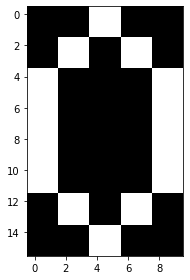

In [355]:
io.imshow(tr.rescale(yLabels[0][:, y_Numbers[0][0]], 2))

In [356]:
y_Numbers

[[[2, 3, 4, 5, 6]],
 [[2, 3, 4, 5, 6], [8, 9, 10, 11, 12]],
 [[2, 3, 4, 5, 6], [8, 9, 10, 11, 12]],
 [[2, 3, 4, 5, 6], [8, 9, 10, 11, 12]],
 [[2, 3, 4, 5, 6], [8, 9, 10, 11, 12], [14, 15, 16, 17, 18]]]

#### recognize xLabel

In [265]:
x_Numbers_resized = []
for i in range(len(x_Numbers)):
    x_numbers_resized = []
    for j in range(len(x_Numbers[i])):
        io.imsave("number_img/{}_{}.png".format(i, j), xLabels[i][:, x_Numbers[i][j]])
        x_numbers_resized.append(resizefig(tr.rescale(xLabels[i][:, x_Numbers[i][j]],2), 10, 10, 50))
    x_Numbers_resized.append(x_numbers_resized)

/home/user/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: number_img/0_0.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  """
/home/user/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: number_img/0_1.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  """
/home/user/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: number_img/1_0.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  """
/home/user/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: number_img/1_1.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  """
/home/user/miniconda/lib/python3.7/site-packages

In [266]:
x_Numbers_resized[0][0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

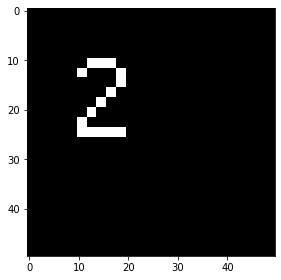

In [268]:
io.imshow(x_Numbers_resized[0][0])

In [269]:
np.expand_dims(x_Numbers_resized[0][0],0).shape

(1, 50, 50)

In [270]:
torch.tensor(x_Numbers_resized[0][0]).to(device)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', dtype=torch.float64)

[0]


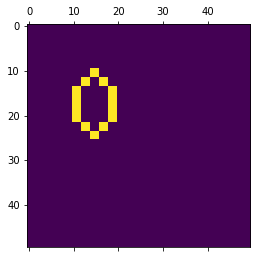

In [308]:
i,j = 9,2
input_tensor = torch.tensor(np.expand_dims(x_Numbers_resized[i][j],0), dtype=torch.float32).to(device)
output = recog_label_model(input_tensor)
        
predict = output.detach().cpu().topk(1)[1].view(-1).numpy()
print(predict)
plt.matshow(x_Numbers_resized[i][j])

In [283]:
output

tensor([[-57.2698, -28.2052, -23.4213, -20.7042, -15.3479, -28.1870, -20.1015,
         -29.0066, -21.7198, -16.4542,  -8.0419]], device='cuda:0',
       grad_fn=<GatherBackward>)

In [281]:
output.detach().cpu().topk(1)

torch.return_types.topk(
values=tensor([[-8.0419]]),
indices=tensor([[10]]))

In [316]:
x_recognized = []
for i in x_Numbers_resized:
    x_recognized_number = []
    for j in i:
        input_tensor = torch.tensor(np.expand_dims(j ,0), dtype=torch.float32).to(device)
        output = recog_label_model(input_tensor)
        predict = output.detach().cpu().topk(1)[1].view(-1).numpy()
        x_recognized_number.append(str(predict[0]))
    digit = "".join(x_recognized_number)
    x_recognized.append(digit)

In [317]:
x_recognized

['20',
 '30',
 '40',
 '50',
 '60',
 '70',
 '80',
 '90',
 '100',
 '110',
 '120',
 '130',
 '140',
 '150',
 '160',
 '170',
 '180',
 '190']

In [318]:
x_label_splits

[[53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],
 [93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107],
 [134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148],
 [174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188],
 [215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229],
 [255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269],
 [296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310],
 [337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351],
 [377,
  378,
  379,
  380,
  381,
  382,
  383,
  384,
  385,
  386,
  387,
  388,
  389,
  390,
  391,
  392,
  393,
  394,
  395,
  396,
  397],
 [418,
  419,
  420,
  421,
  422,
  423,
  424,
  425,
  426,
  427,
  428,
  429,
  430,
  431,
  432,
  433,
  434,
  435,
  436,
  437,
  438],
 [458,
  459,
  460,
  461,
  462,
  463,
  464,
  465,
  466,
  467,
  468,
  469,
  470,
  471,
  47

In [319]:
x_splits[-2]

[561, 562, 563, 564, 565, 566, 567, 568]

In [324]:
x_label_formated = []
for i in range(len(x_recognized)):
    x_label_formated.append([[x_label_splits[i][0], x_splits[-2][0]],
                            [x_label_splits[i][-1], x_splits[-2][0]],
                            [x_label_splits[i][0], x_splits[-2][-1]],
                            [x_label_splits[i][-1], x_splits[-2][-1]],
                            eval(x_recognized[i])])

In [325]:
x_label_formated

[[[53, 561], [67, 561], [53, 568], [67, 568], 20],
 [[93, 561], [107, 561], [93, 568], [107, 568], 30],
 [[134, 561], [148, 561], [134, 568], [148, 568], 40],
 [[174, 561], [188, 561], [174, 568], [188, 568], 50],
 [[215, 561], [229, 561], [215, 568], [229, 568], 60],
 [[255, 561], [269, 561], [255, 568], [269, 568], 70],
 [[296, 561], [310, 561], [296, 568], [310, 568], 80],
 [[337, 561], [351, 561], [337, 568], [351, 568], 90],
 [[377, 561], [397, 561], [377, 568], [397, 568], 100],
 [[418, 561], [438, 561], [418, 568], [438, 568], 110],
 [[458, 561], [478, 561], [458, 568], [478, 568], 120],
 [[499, 561], [519, 561], [499, 568], [519, 568], 130],
 [[540, 561], [560, 561], [540, 568], [560, 568], 140],
 [[580, 561], [600, 561], [580, 568], [600, 568], 150],
 [[621, 561], [641, 561], [621, 568], [641, 568], 160],
 [[661, 561], [681, 561], [661, 568], [681, 568], 170],
 [[702, 561], [722, 561], [702, 568], [722, 568], 180],
 [[743, 561], [763, 561], [743, 568], [763, 568], 190]]

#### recognize yLabel

In [357]:
y_Numbers_resized = []
for i in range(len(y_Numbers)):
    y_numbers_resized = []
    for j in range(len(y_Numbers[i])):
        y_numbers_resized.append(resizefig(tr.rescale(yLabels[i][:, y_Numbers[i][j]],2), 10, 10, 50))
    y_Numbers_resized.append(y_numbers_resized)

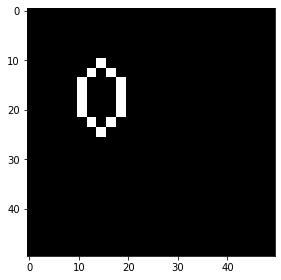

In [358]:
io.imshow(y_Numbers_resized[0][0])

In [359]:
y_recognized = []
for i in y_Numbers_resized:
    y_recognized_number = []
    for j in i:
        input_tensor = torch.tensor(np.expand_dims(j ,0), dtype=torch.float32).to(device)
        output = recog_label_model(input_tensor)
        predict = output.detach().cpu().topk(1)[1].view(-1).numpy()
        y_recognized_number.append(str(predict[0]))
    digit = "".join(y_recognized_number)
    y_recognized.append(digit)

In [360]:
y_recognized

['0', '25', '50', '75', '100']

In [362]:
y_label_splits

[[42, 43, 44, 45, 46, 47, 48, 49, 50],
 [167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181],
 [292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306],
 [417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431],
 [542,
  543,
  544,
  545,
  546,
  547,
  548,
  549,
  550,
  551,
  552,
  553,
  554,
  555,
  556,
  557,
  558,
  559,
  560,
  561,
  562]]

In [363]:
y_splits[1]

[31, 32, 33, 34, 35, 36, 37, 38]

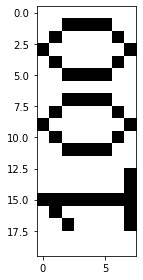

In [378]:
i, j = 600-542, 600-562
io.imshow(ylabel[j:i, :])

In [425]:
y_label_formated = []
for i in range(len(y_recognized)-1, -1, -1): 
    c, d = binary.shape
    b, a = c-y_label_splits[i][0], c-y_label_splits[i][-1]
    y_label_formated.append([[a, y_splits[1][0]],
                            [b, y_splits[1][0]],
                            [a, y_splits[1][-1]],
                            [b, y_splits[1][-1]],
                            eval(y_recognized[i])])

In [426]:
y_label_formated

[[[38, 31], [58, 31], [38, 38], [58, 38], 100],
 [[169, 31], [183, 31], [169, 38], [183, 38], 75],
 [[294, 31], [308, 31], [294, 38], [308, 38], 50],
 [[419, 31], [433, 31], [419, 38], [433, 38], 25],
 [[550, 31], [558, 31], [550, 38], [558, 38], 0]]

### Determine absolute coordinates

#### Get the y-coordinate relationship

In [409]:
horizon_distribution = np.sum(~content, axis=0)

In [410]:
horizon_distribution

array([  5,   5,   5,  21,  21,  21, 501,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   6,   1,   1,   1,   1,   1,   1,   1,   4,   1,
         1,   1,   1,   1,   1,   1,   4,   1,   1,   1,   1,   1,   1,
         1,   8,   1,   1,   1,   4,   1,   1,   1,   4,   1,   1,   1,
         1,   1,   1,   1,   6,   1,   1,   1,   7,   1,   1,   1,   4,
         1,   1,   1,   1,   1,   1,   1,   4,   1,   1,   1,   4,   1,
         1,   1,   6,   1,   1,   1,   1,  13,   1,   1,   1,  17,   1,
         1,   1,   5,   1,   1,   1,   6,   1,   1,   1,   1,   1,   1,
         1,   4,   1,   1,   1,   1,   1,   1,   1,   4,   1,   1,   1,
         1,   1,   1,   1,   4,   1,   1,   1,   1,   1,   1,   1,   4,
         1,   1,   1,   1,   1,   1,   1,  88,   1,   1,   1,  13,   1,
         1,   1,   6,   1,   1,   1,   2,   1,   1,   1,   1,   4,   1,
         1,   1,   3,   1,   1,   1,   9,   1,   1,   1,  12,   1,   1,
         1,   4,   1,   1,   1,   1,   1,   1,   1,  12,   1,   

In [411]:
y_label_bulge = []
temp = horizon_distribution[0]
for i in range(len(horizon_distribution)):
    if horizon_distribution[i] == temp:
        y_label_bulge.append(i)
    else:
        break

In [412]:
y_label_bulge

[0, 1, 2]

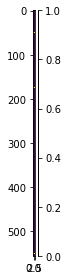

In [413]:
io.imshow(~content[:, y_label_bulge])

In [414]:
vertical_distribution = np.sum(~content[:, y_label_bulge], axis=1)

In [415]:
y_label_bulge_y = []
for i in range(len(vertical_distribution)):
    if vertical_distribution[i]:
        y_label_bulge_y.append(i)

In [416]:
y_label_bulge_y

[50, 175, 300, 425, 550]

In [428]:
y_coordinates = {}
for i in range(len(y_label_bulge_y)):
    y_coordinates[y_label_bulge_y[i]] = y_label_formated[i][-1]

y_coordinates

{50: 100, 175: 75, 300: 50, 425: 25, 550: 0}

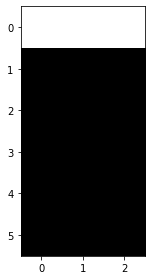

In [498]:
io.imshow(~content[550:560, y_label_bulge])

#### Get the x-coordinate relationship

In [436]:
vertical_distribution = np.sum(~content, axis=1)

In [437]:
vertical_distribution

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   8,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   5,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   5,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   5,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   5,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   8,   2,   2,   2,   2,   

In [438]:
x_label_bulge = []
temp = vertical_distribution[-1]
for i in range(len(vertical_distribution)-1, -1, -1):
    if vertical_distribution[i] == temp:
        x_label_bulge.append(i)
    else:
        break

In [439]:
x_label_bulge

[555, 554]

In [440]:
io.imsave('x_axis.png',~content[x_label_bulge, :])

/home/user/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: x_axis.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  """Entry point for launching an IPython kernel.


In [445]:
horizon_distribution = np.sum(~content[x_label_bulge, :], axis=0)

In [446]:
horizon_distribution

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,

In [450]:
x_label_bulge_x = []
for i in range(len(horizon_distribution)):
    if horizon_distribution[i]:
        x_label_bulge_x.append(i)

x_label_bulge_x

[16,
 56,
 97,
 137,
 178,
 218,
 259,
 300,
 340,
 381,
 421,
 462,
 503,
 543,
 584,
 624,
 665,
 706]

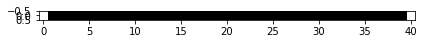

In [455]:
io.imshow(~content[554:555, 16:57])

In [456]:
x_coordinates = {}
for i in range(len(x_label_bulge_x)):
    x_coordinates[x_label_bulge_x[i]] = x_label_formated[i][-1]

x_coordinates

{16: 20,
 56: 30,
 97: 40,
 137: 50,
 178: 60,
 218: 70,
 259: 80,
 300: 90,
 340: 100,
 381: 110,
 421: 120,
 462: 130,
 503: 140,
 543: 150,
 584: 160,
 624: 170,
 665: 180,
 706: 190}

#### Regression determines the relationship between picture coordinates and real coordinates

In [467]:
from sklearn.linear_model import LinearRegression


In [479]:
x = np.array(list(x_coordinates.keys())).reshape((-1, 1))
y = np.array(list(x_coordinates.values()))

In [484]:
x_label_model = LinearRegression()
x_label_model.fit(x, y)

x_label_model.score(x, y)

0.9999979720010675

In [485]:
x = np.array(list(y_coordinates.keys())).reshape((-1, 1))
y = np.array(list(y_coordinates.values()))

In [486]:
y_label_model = LinearRegression()
y_label_model.fit(x, y)

y_label_model.score(x, y)

1.0

#### Determine the spectral value coordinates

In [494]:
temp = np.sum(~content, axis=0) - 1 
for i in range(len(temp)):
    if temp[i] == 0:
        start = i
        break



In [501]:
content_list = []
a, b = content.shape
for i in range(start, b):
    for j in range(a):
        if ~content[j][i]:
            x, y = x_label_model.predict(np.array(i).reshape((-1, 1)))[0], y_label_model.predict(np.array(j).reshape((-1, 1)))[0]
            if abs(y) > 1e-6:
                content_list.append({x:y})
            break
content_list

[{26.026720380432003: 0.7999999999999972},
 {27.01217551606613: 0.5999999999999943},
 {30.953996058602627: 1.1999999999999886},
 {34.89581660113912: 0.5999999999999943},
 {35.88127173677324: 0.3999999999999915},
 {37.113090656315904: 2.3999999999999915},
 {38.09854579195002: 2.5999999999999943},
 {39.08400092758415: 0.7999999999999972},
 {49.924007419559516: 16.39999999999999},
 {50.90946255519364: 2.3999999999999915},
 {51.89491769082776: 0.3999999999999915},
 {52.88037282646189: 0.19999999999998863},
 {55.09764688163867: 0.3999999999999915},
 {56.08310201727279: 0.9999999999999858},
 {57.06855715290691: 2.1999999999999886},
 {60.02492255980928: 1.1999999999999886},
 {61.01037769544341: 2.5999999999999943},
 {61.995832831077536: 3.3999999999999915},
 {62.98128796671166: 2.999999999999986},
 {63.96674310234578: 0.3999999999999915},
 {64.9521982379799: 0.19999999999998863},
 {66.92310850924815: 0.19999999999998863},
 {67.90856364488228: 1.5999999999999943},
 {68.8940187805164: 16.799999